### Import Libraries

In [60]:
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns
%matplotlib inline

### Import Data

FBI City and National Data

In [2]:
city_path = pathlib.Path("C:/Users/Barbieri/DSC-Program/Capstone/Literature Review/City_Crime_Rates.xlsx")
national_path = pathlib.Path("C:/Users/Barbieri/DSC-Program/Capstone/Literature Review/National_Crime_Rates.xlsx")

In [3]:
city_crime_rates = pd.read_excel(city_path, sheet_name='data')
national_crime_rates = pd.read_excel(national_path, sheet_name='data')

Crime/Weather/Census Dataset

In [18]:
conn = sqlite3.connect('C:/Users/Barbieri/DSC-Program/DC-Criminalistics/data/crime_census_weather_tod.db')

df_all = pd.read_sql('''select * from all_crimes;''', conn)
df_type = pd.read_sql('''select * from by_crime_type;''', conn)

conn.close()

Weather Data

In [3]:
conn = sqlite3.connect('c:/users/barbieri/dsc-program/DC-Criminalistics/data/weather-data/weather_data.db')
weather_df = pd.read_sql('''select * from weather_data;''', conn)
conn.close()

# Figure 1

### Wrangle City Data

Create city label.

In [4]:
def create_city(row):
    cl = row['Agency'].split(' ')
    
    if cl[0] == 'Los' or cl[0] == 'Las':
        cty = "{} {}, {}".format(cl[0], cl[1], row['State'])
    elif cl[0] == 'New':
        cty = "{} {} {}, {}".format(cl[0], cl[1], cl[2], row['State'])
    else:
        cty = "{}, {}".format(cl[0], row['State'])
        
    return cty

In [5]:
city_crime_rates['city'] = city_crime_rates.apply(create_city, axis=1)

Drop columns and transpose.

In [6]:
city_crime_rates.drop(columns=['Agency', 'Importance', 'State'], inplace=True)

In [7]:
city_crime_rates_t = pd.DataFrame(columns=['year','crime_rate','city'])

for index, row in city_crime_rates.iterrows():
    #Capture city name.
    city = row['city']
    
    #Turn series into dataframe.
    col = row.reset_index()
    
    #Drop where index equals the city name.
    col = col.loc[col['index'] != 'city']
    
    #Create column called city equal to the city name.
    col['city'] = city
    
    #Rename index to year of crime rate and set crime rate values to crime_rate.
    col.rename(columns={'index':'year', list(col.columns)[1]:'crime_rate'}, inplace=True)
    
    #Append to final dataframe.
    city_crime_rates_t = city_crime_rates_t.append(other=col, ignore_index=True, sort=False)

### Plot Data

In [8]:
cities = city_crime_rates_t['city'].unique()
cities = ['Los Angeles, CA', 'Washington, DC','New York City, NY', 'Philadelphia, PA','Seattle, WA']

In [9]:
city_crime_rates_t['year'].unique()[0::6]

array([1985, 1991, 1997, 2003, 2009], dtype=object)

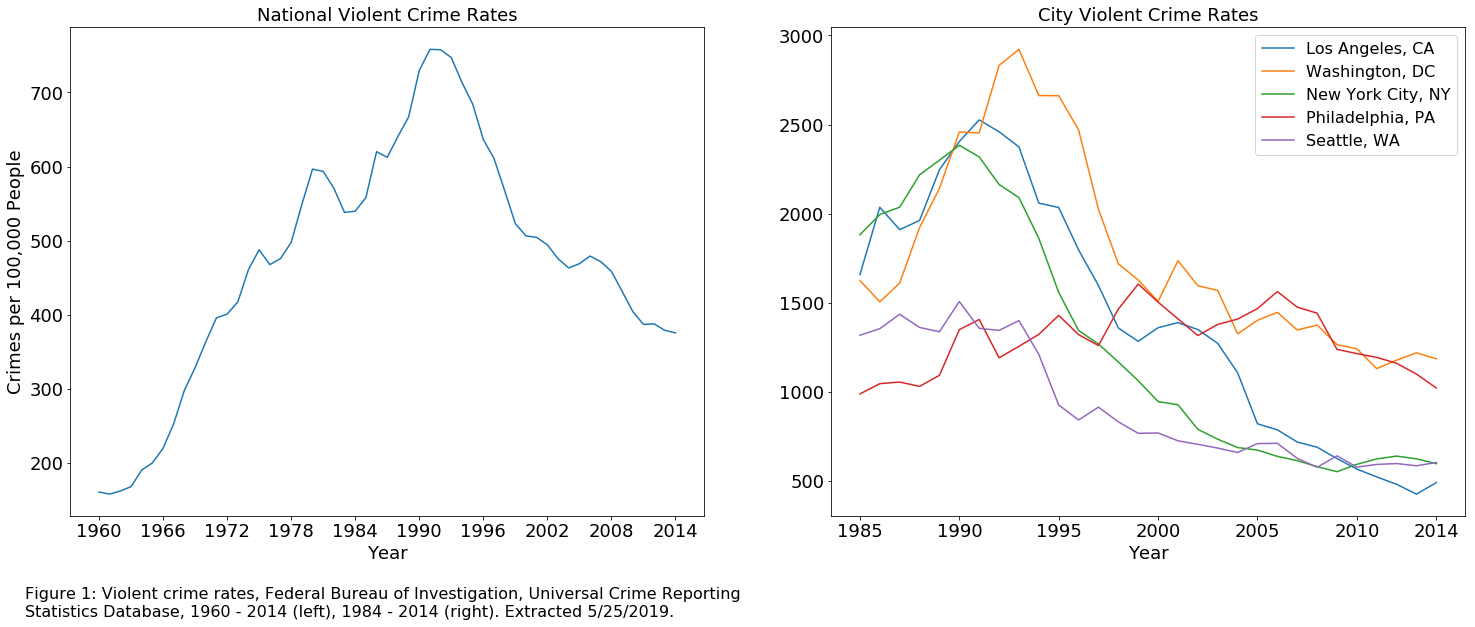

In [76]:
#Create Figure and Axes
fig = plt.figure(figsize=(25,9))
plt.rc('ytick',labelsize=18)
plt.rc('xtick',labelsize=18)
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=18)
plt.rc('legend', fontsize=16)

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

#Edit Figure Text
fig.text(0.1, -0.03, 'Figure 1: Violent crime rates, Federal Bureau of Investigation, Universal Crime Reporting \nStatistics Database, \
1960 - 2014 (left), 1984 - 2014 (right). Extracted 5/25/2019.',
         horizontalalignment='left',fontsize=16)

#Set X Axes
ax1.title.set_text('National Violent Crime Rates')
ax1.set_ylabel('Crimes per 100,000 People')
ax1.set_xlabel('Year')
ax1.set_xticks(national_crime_rates['Year'].iloc[0::6])
ax1.plot(national_crime_rates['Year'], national_crime_rates['Violent Crime rate'])

#Set Y Axis
ax2.title.set_text('City Violent Crime Rates')
ax2.set_xlabel('Year')
ax2.set_xticks([1985, 1990, 1995, 2000, 2005, 2010, 2014])
for city in cities:
    x = city_crime_rates_t.loc[city_crime_rates_t['city'] == city, 'year']
    y = city_crime_rates_t.loc[city_crime_rates_t['city'] == city, 'crime_rate']
    
    ax2.plot(x,y)

ax2.legend(cities)

#Export as PNG
fig.savefig('Figure 1.png', bbox_inches='tight')

# Table 1

In [16]:
columns = {'currently_apparentTemperature':'Temperature (Feels-like)',
           'currently_precipIntensity':'Percipitation Intensity',
           'currently_precipProbability':'Precipitation Probability',
           'currently_temperature': 'Temperature'}

weather_df.rename(columns=columns)[list(columns.values())].describe()

,Temperature (Feels-like),Percipitation Intensity,Precipitation Probability,Temperature
count,379998.000000,379970.000000,379970.000000,379998.000000
mean,60.520131,0.002611,0.062602,60.260285
std,19.214837,0.014812,0.195211,17.658149
min,-5.720000,0.000000,0.000000,3.010000
25%,45.490000,0.000000,0.000000,46.222500
50%,62.220000,0.000000,0.000000,62.170000
75%,75.250000,0.000000,0.000000,74.590000
max,116.900000,0.774600,1.000000,102.040000


# Table 3

In [53]:
columns = ['Time Category','Time']

tod = [['Midnight','11pm - 2am'], ['Late Night','2am - 5am'],
       ['Early Morning','5am - 8am'], ['Morning','8am - 11am'],
       ['Afternoon','11am - 2pm'], ['Mid Afternoon','2pm - 5pm'],
       ['Evening','5pm - 8pm'], ['Night', '8pm - 11pm']]

In [54]:
pd.DataFrame(data=tod, columns=columns)

,Time Category,Time
0,Midnight,11pm - 2am
1,Late Night,2am - 5am
2,Early Morning,5am - 8am
3,Morning,8am - 11am
4,Afternoon,11am - 2pm
5,Mid Afternoon,2pm - 5pm
6,Evening,5pm - 8pm
7,Night,8pm - 11pm


# Table 4

In [55]:
columns = ['crime_rate','temperature','percip_probability','percip_intensity',
           'uv_index','PerCapitaIncome', 'MedianHouseholdInc','HousingUnits']

In [56]:
df_all[columns].describe()

,crime_rate,temperature,percip_probability,percip_intensity,uv_index,PerCapitaIncome,MedianHouseholdInc,HousingUnits
count,104807.000000,104807.000000,104807.000000,104807.000000,104807.000000,104807.000000,104807.000000,104807.000000
mean,144.846938,58.939106,0.063081,0.002486,1.497117,46324.745027,76200.517292,732.975889
std,147.654580,17.229707,0.170581,0.011756,2.203358,28838.111670,45297.277149,370.799930
min,18.494544,3.010000,0.000000,0.000000,0.000000,3787.000000,6548.000000,10.000000
25%,68.050365,45.180000,0.000000,0.000000,0.000000,23133.000000,39648.000000,482.000000
50%,104.493208,60.885000,0.000000,0.000000,0.000000,38852.000000,68780.000000,645.000000
75%,167.037862,72.980000,0.000000,0.000000,2.333333,65135.000000,102900.000000,922.000000
max,3505.535055,98.340000,1.000000,0.388300,11.000000,220398.000000,250001.000000,3325.000000


# Figure 3

In [57]:
order = ['Early Morning', 'Morning', 'Afternoon',
         'Mid Afternoon', 'Evening', 'Night',
         'Midnight','Late Night']

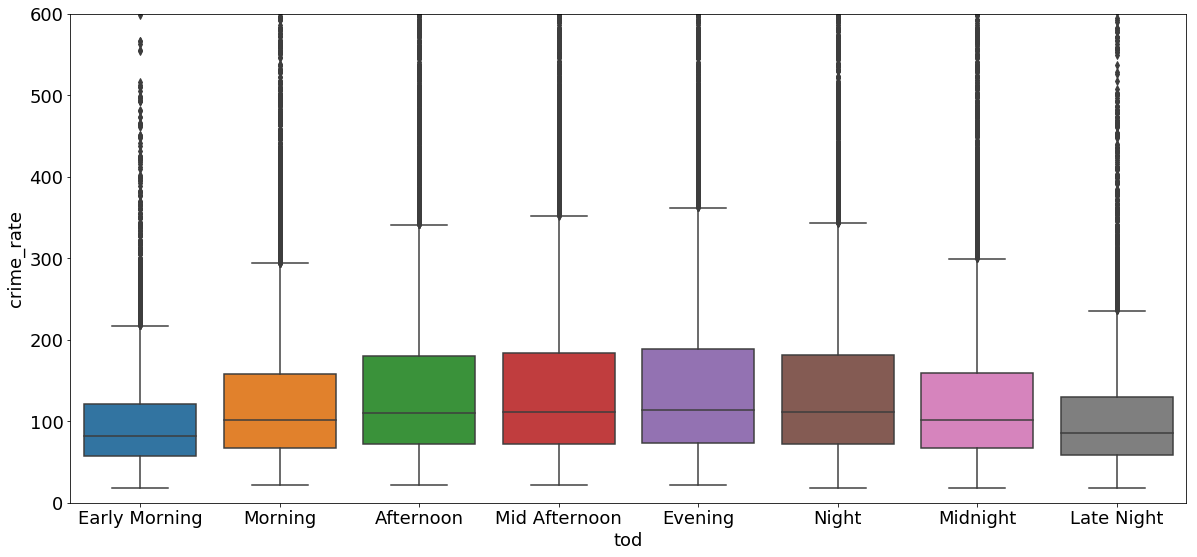

In [61]:
fig = plt.figure(figsize=(20,9))
plt.rc('ytick',labelsize=18)
plt.rc('xtick',labelsize=18)
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=18)
plt.rc('legend', fontsize=16)

ax1 = fig.add_subplot(1,1,1)
ax1.set(ylim=(0,600))

sns.boxplot(x="tod", y="crime_rate", data=df_all, ax=ax1, order=order)

plt.show()

# Figure 4

In [63]:
cols = ['crime_rate', 'apparent_temp',
        'percip_probability', 'percip_intensity',
        'uv_index','humidity']

pp = df_all[cols]

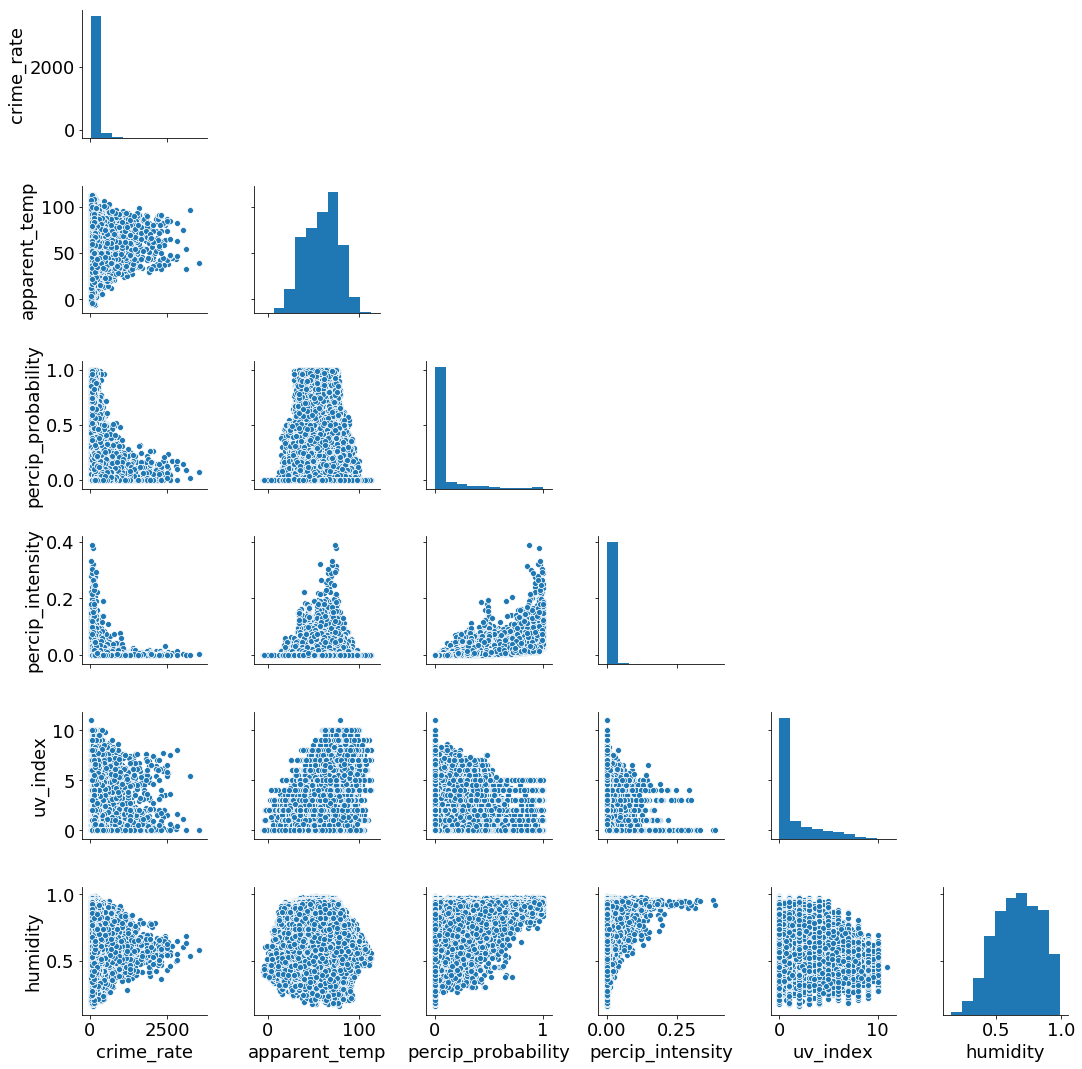

In [64]:
ax = sns.pairplot(pp)

for i, j in zip(*np.triu_indices_from(ax.axes, 1)):
    ax.axes[i, j].set_visible(False)